<a href="https://colab.research.google.com/github/daspartho/MagicMix/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of [MagicMix: Semantic Mixing with Diffusion Models](https://arxiv.org/pdf/2210.16056.pdf) paper
### by [Partho Das](https://github.com/daspartho)

### Installing required libraries

In [1]:
!pip install diffusers transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import and Setup

In [2]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer, logging
import torch
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from PIL import Image
from IPython import display

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

### Loading the components we'll use

In [3]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
).to(device)

vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "vae",
).to(device)

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "unet",
).to(device)

beta_start,beta_end = 0.00085,0.012
scheduler = DDIMScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False, 
    set_alpha_to_one=False,
)

### Some helpful functions

In [4]:
# convert PIL image to latents
def encode(img):
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(img).unsqueeze(0).to(device)*2-1)
        latent = 0.18215 * latent.latent_dist.sample()
    return latent

# convert latents to PIL image
def decode(latent):
    latent = (1 / 0.18215) * latent
    with torch.no_grad():
        img = vae.decode(latent).sample
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype("uint8")
    return Image.fromarray(img[0])

In [5]:
# convert prompt into text embeddings, also unconditional embeddings
def prep_text(prompt):

    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embedding = text_encoder(
        text_input.input_ids.to(device)
    )[0]

    uncond_input = tokenizer(
        "",
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    uncond_embedding = text_encoder(
        uncond_input.input_ids.to(device)
    )[0]

    return torch.cat([uncond_embedding, text_embedding])

### MagicMix

In [6]:
def magic_mix(
    img, # specifies the layout semantics
    prompt, # specifies the content semantics
    kmin=15,
    kmax=30,
    v=0.5, # interpolation constant
    seed=42,
    steps=50,
    guidance_scale=7.5,
):

    tmin = steps-kmin
    tmax = steps-kmax

    text_embeddings = prep_text(prompt)

    scheduler.set_timesteps(steps)

    width, height = img.size
    encoded = encode(img)

    torch.manual_seed(seed)
    noise = torch.randn(
        (1,unet.in_channels,height // 8,width // 8),
    ).to(device)

    latents = scheduler.add_noise(
        encoded, 
        noise, 
        timesteps=scheduler.timesteps[tmax]
    )

    input = torch.cat([latents]*2)
                
    input = scheduler.scale_model_input(input, scheduler.timesteps[tmax])

    with torch.no_grad():
        pred = unet(
            input, 
            scheduler.timesteps[tmax],
            encoder_hidden_states=text_embeddings,
        ).sample

    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    latents = scheduler.step(pred, scheduler.timesteps[tmax], latents).prev_sample

    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if i > tmax:
            if i < tmin: # layout generation phase
                orig_latents = scheduler.add_noise(
                    encoded, 
                    noise, 
                    timesteps=t
                )
                
                input = (v*latents) + (1-v)*orig_latents # interpolating between layout noise and conditionally generated noise to preserve layout sematics
                input = torch.cat([input]*2)

            else: # content generation phase
                input = torch.cat([latents]*2)
                
            input = scheduler.scale_model_input(input, t)

            with torch.no_grad():
                pred = unet(
                    input, 
                    t,
                    encoder_hidden_states=text_embeddings,
                ).sample

            pred_uncond, pred_text = pred.chunk(2)
            pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

            latents = scheduler.step(pred, t, latents).prev_sample

    return decode(latents)

### Reproducing some examples from the paper

In [7]:
!curl --output test.jpg 'https://images.unsplash.com/photo-1565277441243-2be39689f95b?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=729&q=80'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47574  100 47574    0     0   228k      0 --:--:-- --:--:-- --:--:--  227k


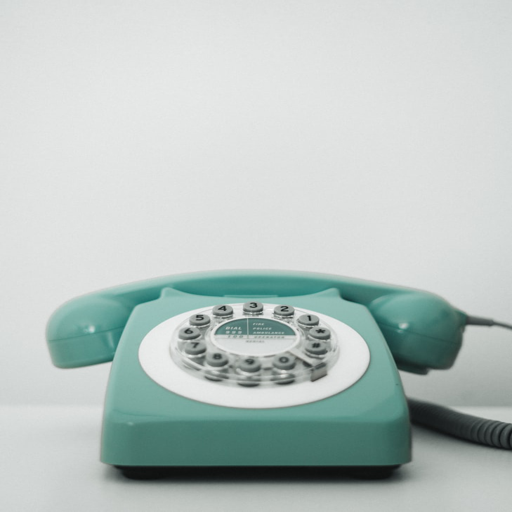

In [8]:
img = Image.open('test.jpg').resize((512, 512))
display.display(img)

  0%|          | 0/50 [00:00<?, ?it/s]

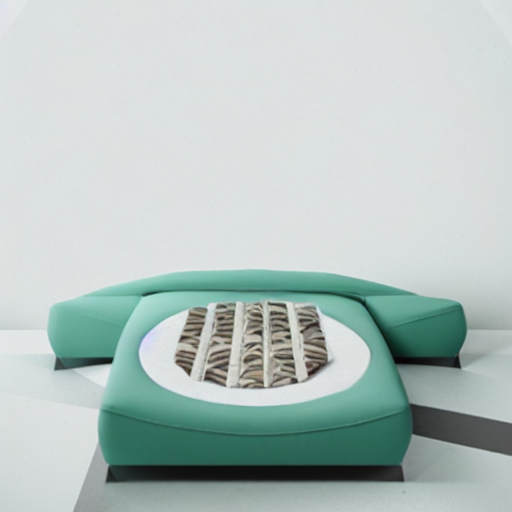

In [9]:
out_img = magic_mix(img, 'bed', kmax=25)
display.display(out_img)

In [10]:
!curl --output test.jpg 'https://images.unsplash.com/photo-1582211713340-dec9934f6b48?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=880&q=80'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62945  100 62945    0     0   458k      0 --:--:-- --:--:-- --:--:--  458k


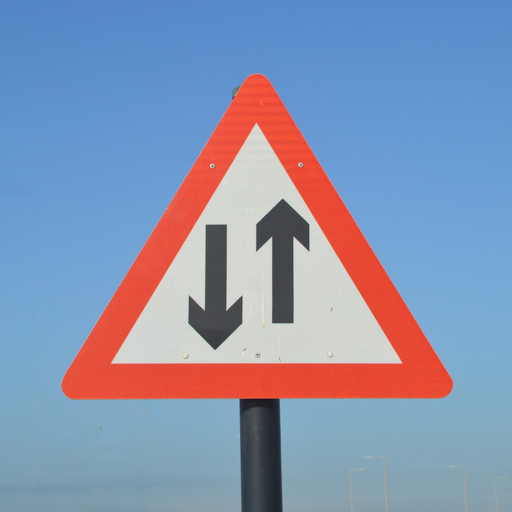

In [11]:
img = Image.open('test.jpg').resize((512, 512))
display.display(img)

  0%|          | 0/50 [00:00<?, ?it/s]

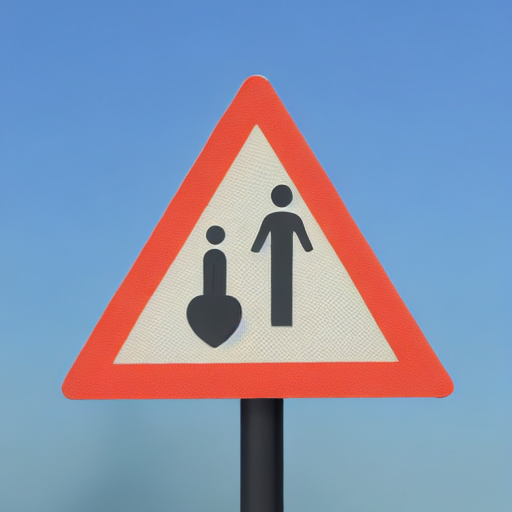

In [12]:
out_img = magic_mix(img, 'family')
display.display(out_img)

In [13]:
!curl --output test.jpg 'https://images.unsplash.com/photo-1607247098731-5bf6416d2e8c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  102k  100  102k    0     0  1118k      0 --:--:-- --:--:-- --:--:-- 1118k


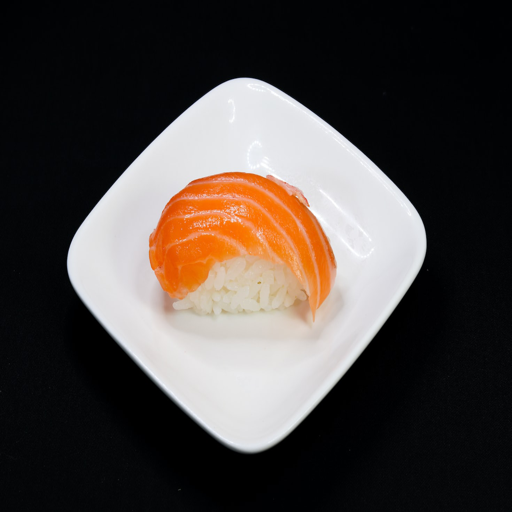

In [14]:
img = Image.open('test.jpg').resize((512, 512))
display.display(img)

  0%|          | 0/50 [00:00<?, ?it/s]

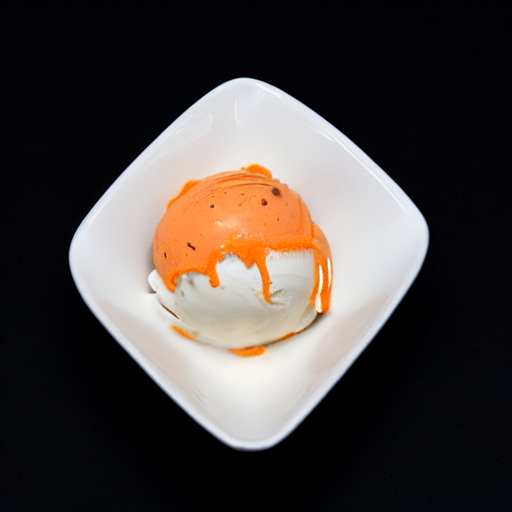

In [15]:
out_img = magic_mix(img, 'ice cream')
display.display(out_img)

In [16]:
!curl --output test.jpg 'https://images.unsplash.com/photo-1550258987-190a2d41a8ba?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=687&q=80'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76302  100 76302    0     0   723k      0 --:--:-- --:--:-- --:--:--  723k


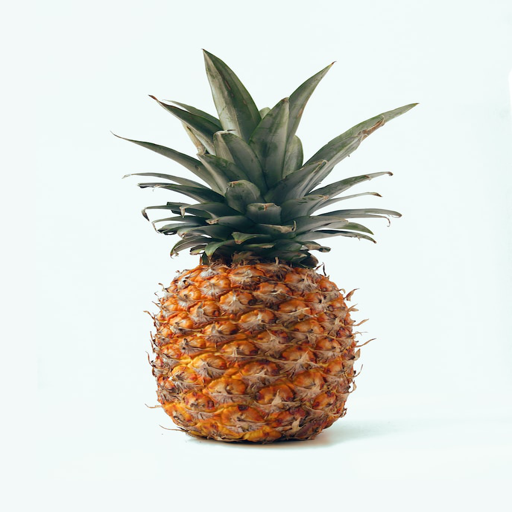

In [17]:
img = Image.open('test.jpg').resize((512, 512))
display.display(img)

  0%|          | 0/50 [00:00<?, ?it/s]

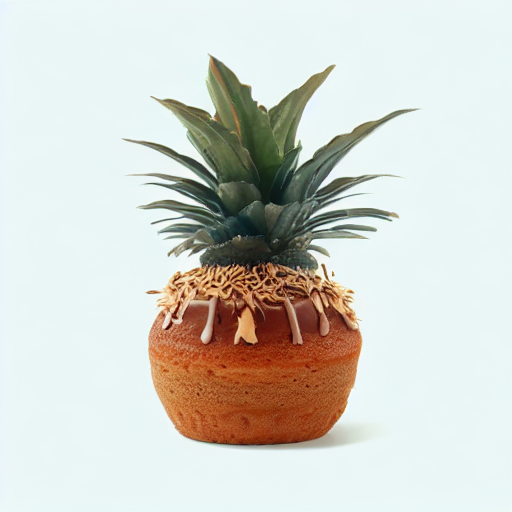

In [18]:
out_img = magic_mix(img, 'cake', kmax=25)
display.display(out_img)

### Gradio App (putting it here for now)

In [19]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gradio as gr


iface = gr.Interface(
    description = "Implementation of MagicMix: Semantic Mixing with Diffusion Models paper",
    article = "<p style='text-align: center'><a href='https://github.com/daspartho/MagicMix' target='_blank'>Github</a></p>",
    fn=magic_mix, 
    inputs=[
        gr.Image(shape=(512,512), type="pil"),
        gr.Text(),
        gr.Slider(value=15),
        gr.Slider(value=30),
        gr.Slider(value=0.5,minimum=0, maximum=1, step=0.1),
        gr.Number(value=42, maximum=2**64-1),
        gr.Slider(value=50),
        gr.Slider(value=7.5, minimum=1, maximum=15, step=0.1),
        ],
    outputs=gr.Image(),
    title="MagicMix"
    )

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>